## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.. <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [21]:
# paths, folders/files
import os, sys, random
from os import listdir
from glob import glob
from zipfile import ZipFile

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image

# NLP
# from bs4 import BeautifulSoup
import re, string
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

# NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pandas version 2.2.1

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Fonctions


### 0.3 Variables globales


In [22]:
nb_classes = 3
target_size=(101, 101)


### 0.4 Data


In [23]:
data = pd.read_csv('./data/data.csv', sep=',')

print(data.shape)
data.head()


(723, 8)


,photo_path,breed,width,height,resized,expo,contraste,denoised
0,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,500,333,./data/resized/Maltese_dog/n02085936_4262.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....
1,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,500,375,./data/resized/Maltese_dog/n02085936_10610.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....
2,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,400,500,./data/resized/Maltese_dog/n02085936_4004.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....
3,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,500,333,./data/resized/Maltese_dog/n02085936_500.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....
4,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,500,375,./data/resized/Maltese_dog/n02085936_10199.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....


### 0.5 Etude de faisabilité (sort of)


In [24]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# bloc d'encodage, sans utiliser d'algorithme de prediction supervisée
# (algo classique ou plutôt, ici, bloc des layers fully connected)

images_features = []

for image_file in data["denoised"] :
    image = load_img(image_file, target_size=(180, 180))
    image = img_to_array(image)
    images_features.append(image)

images_features = np.asarray(images_features)
images_features.shape


(723, 180, 180, 3)

In [25]:
# Reshape images to flatten them into vectors
flattened_images = images_features.reshape(images_features.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)


### 0.6 Réduction dim


In [26]:
# PCA

print(normalized_images.shape)

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

print(feat_pca.shape)

# dimention divisée par 200 (presque), en conservant 99% de la variance !


(723, 97200)
(723, 483)


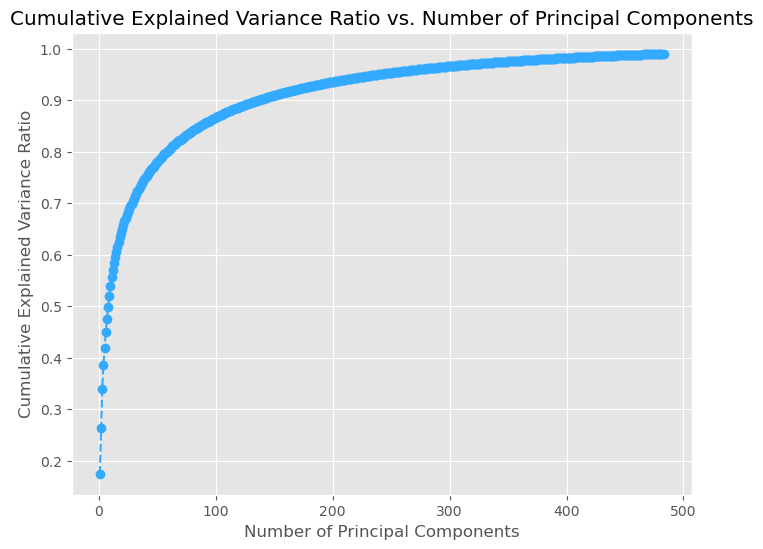

In [27]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.7 tsne


In [28]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


In [31]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,width,height,resized,expo,contraste,denoised,target
0,./data/raw_data/Images/n02085936-Maltese_dog/n...,maltese_dog,500,333,./data/resized/Maltese_dog/n02085936_4262.jpg,./data/expo/./data/resized/maltese_dog/n020859...,./data/contraste/./data/expo/./data/resized/ma...,./data/denoised/./data/contraste/./data/expo/....,1


,photo_path,breed,width,height,resized,expo,contraste,denoised,target
722,./data/raw_data/Images/n02092002-Scottish_deer...,scottish_deerhound,500,402,./data/resized/Scottish_deerhound/n02092002_14...,./data/expo/./data/resized/scottish_deerhound/...,./data/contraste/./data/expo/./data/resized/sc...,./data/denoised/./data/contraste/./data/expo/....,2


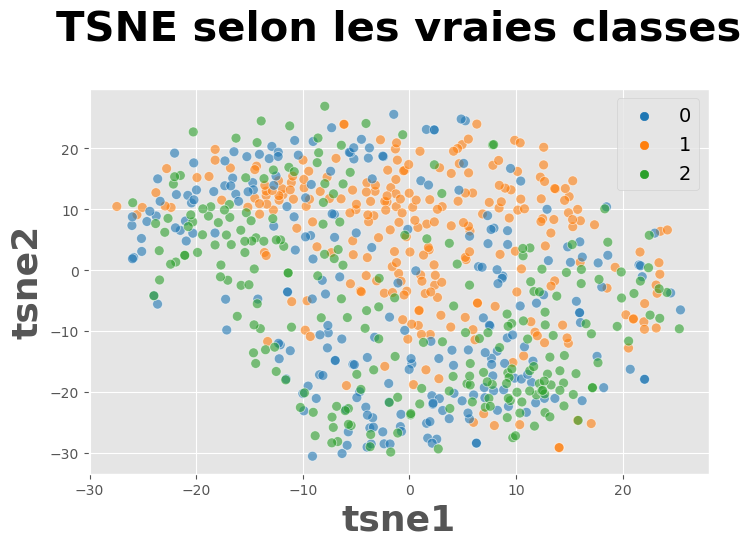

In [32]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

# Ca marche moins bien sans extraction de features !
# On retentera en fin de notebook, en utilisant notre modèle.


### 1 Création d'un premier modèle


In [ ]:
# Notre objectifs principal ici est
# de pouvoir observer / comprendre la fonction des différentes layers utilisées.

# Pour cela, nous allons commencer par une architecture très simple :
# le but n'est pas d'avoir le modèle le + performant possible.
# (irréaliste ici car on n'aurait ni le tps ni les ressources pour l'entrainer)
# (en revanche, voir le notebook 3, transfer learning, pour une comparaison de modèles + complexes)

# Première idée :
# Notre modèle de base sera donc inspiré d'AlexNet, dont l'architecture est :

# "AlexNet contains eight layers: the first five are convolutional layers,
# some of them followed by max-pooling layers, and the last three are fully connected layers.
# [...] The entire structure can be written as:

# (CNN -> RN -> MP)^2 -> (CNN^3 -> MP) -> (FC -> DO)^2 -> Linear -> softmax

# where
# CNN = convolutional layer (with ReLU activation)
# RN = local response normalization
# MP = maxpooling
# FC = fully connected layer (with ReLU activation)
# Linear = fully connected layer (without activation)
# DO = dropout

# It used the non-saturating ReLU activation function, which showed improved training performance
# over tanh and sigmoid." (wiki)


### 1.1 LeNet inspired architecture


In [34]:
# Problème : 8 layers... (16 individuelles) C'est déjà beaucoup !
# On peut faire + simple, au moins pour commencer.

# Voyons de quoi sera capable un modèle inspiré plutôt par LeNet-5
# et par ce notebook : https://www.kaggle.com/code/schmoyote/simple-cnn-architecture-for-image-classification/notebook

model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(101, 101, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(120, activation='tanh'))
model.add(Dense(60, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 97, 97, 6)         456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                                                                 
 dense_4 (Dense)             (None, 60)               

### 1.2 feature engineering


In [20]:
X_feature = []

for image_file in data["denoised"] :
    image = load_img(image_file, target_size=target_size)
    image = img_to_array(image)
    # image = np.expand_dims(image, axis=0)
    # image = preprocess_input(image)
    X_feature.append(image) # predict from pretrained model

X_feature = np.asarray(X_feature)
X_feature.shape


(723, 100, 100, 3)

In [ ]:
# Ici une simple normalisation de la valeur des pixels
# + transfo en tensor pour tf

def load_and_normalize(img_address):
    image = load_img(img_address, target_size=(180, 180)) # redondant (target_size)
    image = img_to_array(image)
    # image = tf.convert_to_tensor(image)
    return image


data['input'] = data['denoised'].apply(load_and_normalize)

# data.head(1)


### 1.3 train test split


In [ ]:
# ttsplit

feature = 'input'
target = 'target' # 'breed' ?

train_val_df, test_df = train_test_split(data[[feature, target]], test_size=0.1, random_state=42)
train_val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)


In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

# train_df.head() # 1 min ???


(585, 2)
(65, 2)
(73, 2)


In [ ]:
# Train the model
model.fit(np.asarray(train_df[feature]), np.asarray(train_df[target]), epochs=20, batch_size=32,
          validation_data=(np.asarray(val_df[feature]), np.asarray(val_df[target])))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_df[feature], test_df[target])
print('Test accuracy:', test_acc)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

### Ameliorations


In [ ]:
# Activation Functions: Tanh activation functions are commonly used in LeNet, but you might
# experiment with other activation functions like ReLU (Rectified Linear Unit), which tend to perform well
#  in many scenarios.

# Optimizer: The Adam optimizer is a good choice, but you might also experiment with other optimizers
# such as RMSprop or SGD (Stochastic Gradient Descent) with momentum.

# Loss Function: Cross-entropy loss is appropriate for classification tasks with softmax activation
# in the output layer, so categorical_crossentropy is fine.

# Model Capacity: LeNet is a relatively shallow network compared to modern architectures.
# Depending on the complexity of your dataset, you might need to adjust the model's capacity
# by adding more convolutional layers or increasing the number of units in the fully connected layers.

# Regularization: You may consider adding regularization techniques such as dropout or weight decay
# to prevent overfitting, especially if you observe overfitting during training.

# smaller grids ?
# modify input shape ?

# inception module + global average pooling ?
